# Circular waveguide filter - Discussion

In [31]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/circular_waveguide_filter')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import time
import numpy as np
import matplotlib.pyplot as plt

import fenics as fen
from circular_waveguide_filter import CircularWaveguideFilter

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

### Dimensions and properties

In [33]:
# Dimensions in meters
Lc = 0.04387  # Length of the cavities
Ls = 0.00150  # Length of the slots
Lr = 0.02000  # Length of rectangular input/output WR75-waveguide
Hr = 0.009525 # Height of rectangular input/output WR75-waveguide
Wr = 0.01905  # Width of rectangular input/output WR75-waveguide

Dx = Ls/2 + Lc + Ls + Lr  # |x|-coordinate of input/output boundary
Dy = Wr/2  # |y|-limit of input/output boundary
Dz = Hr/2  # |z|-limit of input/output boundary

In [34]:
class B_N(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(abs(x[0]), Dx) and x[1]>-Dy and x[1]<Dy and x[2]>-Dz and x[2]<Dz

class g_N_L(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        #value[2] = 1.0 / (4e-7*np.pi) if fen.near(x[0], -Dx) else 0.0
        value[2] = 1.0 if fen.near(x[0], -Dx) and x[1] > -Dy and x[1] < Dy and x[2] > -Dz and x[2] < Dz else 0.0
    def value_shape(self):
        return (3,)

class g_N_R(fen.UserExpression):
    def eval(self, value, x):
        value[0] = 0.0
        value[1] = 0.0
        #value[2] = - 1.0 / (4e-7*np.pi) if fen.near(x[0], Dx) else 0.0
        value[2] = - 1.0 if fen.near(x[0], Dx) and x[1] > -Dy and x[1] < Dy and x[2] > -Dz and x[2] < Dz else 0.0
    def value_shape(self):
        return (3,)

mesh = os.getcwd() + '/model/DMCWF.xml'
CWF = CircularWaveguideFilter(mesh, B_N, g_N=[g_N_L(), g_N_R()])
VS = VectorSpaceL2(CWF)
CWF.setup()

### Solution of problem

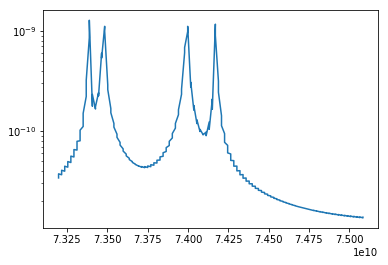

In [35]:
#a = 2*np.pi*9.5e+9
#b = 2*np.pi*11e+9
a = 2*np.pi*1.165e+10
b = 2*np.pi*1.195e+10
fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
omegas = np.linspace(a, b, 100)
CWF.solve(omegas, solver='fenics')
CWF.save_solution('snapshots/linspace_1.165e+10_1.195e+10_100_gN1.obj')
#CWF.load_solution('snapshots/linspace_1.165e+10_1.195e+10_100.obj')
helpers.plot_solution_norms(ax, CWF, VS)

#### Analyzing scattering coefficients

In [36]:
def get_interpolatory_solutions(omega, CWF_L, CWF_R, VS):
    omega_test = np.linspace(np.min(omega), np.max(omega), 1000)
    MRI = MinimalRationalInterpolation(VS)
    MRI_L_hist = MRI.compute_surrogate(CWF_L, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_L = MRI.evaluate_surrogate(CWF_L.get_solution(), omega).T
    MRI_R_hist = MRI.compute_surrogate(CWF_R, omegas=omega_test, greedy=True, tol=1e-2, solver='fenics', return_history=True)
    U_MRI_R = MRI.evaluate_surrogate(CWF_R.get_solution(), omega).T
    U_MRI = np.empty((2*len(omega), U_MRI_R.shape[1]), dtype=complex)
    U_MRI[::2] = U_MRI_L
    U_MRI[1::2] = U_MRI_R
    return U_MRI, MRI_L_hist, MRI_R_hist

In [37]:
def compute_scattering_matrices(F, U, freq, freq_c=6.56e+9, freq_0=1e+10):
    N = len(freq) // 2
    S = [np.empty((2, 2), dtype=complex)] * N
    for n in range(N):
        S[n][0, 0] = np.inner(F[0], U[2*n])
        S[n][0, 1] = np.inner(F[1], U[2*n])
        S[n][1, 0] = np.inner(F[0], U[2*n+1])
        S[n][1, 1] = np.inner(F[1], U[2*n+1])
        S[n] *= 1j*freq[n]*np.sqrt((1 - (freq_c/freq_0)**2) / (1 - (freq_c / freq[n])**2))
        S[n] = np.eye(2) - 2 * np.linalg.inv(np.eye(2) + S[n])
    return S

In [38]:
def get_scattering_coefficients(S):
    S11 = np.abs(S)[:, 0, 0]
    S21 = np.abs(S)[:, 1, 0]
    S12 = np.abs(S)[:, 0, 1]
    S22 = np.abs(S)[:, 1, 1]
    return S11, S21, S12, S22

In [51]:
def convert_to_dezibel(x):
    return 20*np.log(x / np.max(x))

In [39]:
freq = CWF.get_frequency()

F = CWF.get_L(tonumpy=True) + CWF.get_N(tonumpy=True)
U_FEM = CWF.get_solution()

CWF_L = CircularWaveguideFilter(mesh, B_N, g_N=g_N_L())
CWF_L.setup()
CWF_R = CircularWaveguideFilter(mesh, B_N, g_N=g_N_R())
CWF_R.setup()
U_MRI, MRI_L_hist, MRI_R_hist = get_interpolatory_solutions(freq[::2], CWF_L, CWF_R, VS)

S_FEM = compute_scattering_matrices(F, U_FEM, freq)
S_MRI = compute_scattering_matrices(F, U_MRI, freq)

S11_FEM, S21_FEM, S12_FEM, S22_FEM = get_scattering_coefficients(S_FEM)
S11_MRI, S21_MRI, S12_MRI, S22_MRI = get_scattering_coefficients(S_MRI)

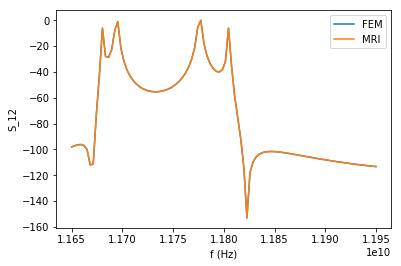

In [53]:
plt.plot(freq[::2] / (2*np.pi), convert_to_dezibel(S12_FEM), label='FEM')
plt.plot(freq[::2] / (2*np.pi), convert_to_dezibel(S12_MRI), label='MRI')
plt.ylabel('S_12')
plt.xlabel('f (Hz)')
plt.legend()

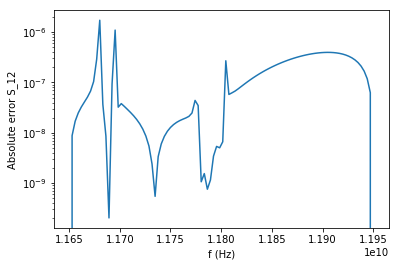

In [57]:
plt.plot(freq[::2] / (2*np.pi), np.abs(S12_FEM - S12_MRI))
plt.ylabel('Absolute error S_12')
plt.xlabel('f (Hz)')
plt.yscale('log')

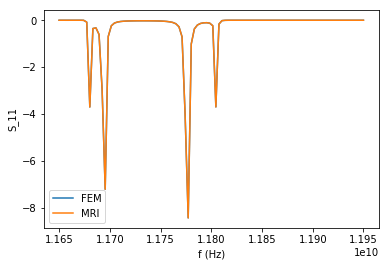

In [54]:
plt.plot(freq[::2] / (2*np.pi), convert_to_dezibel(S11_FEM), label='FEM')
plt.plot(freq[::2] / (2*np.pi), convert_to_dezibel(S11_MRI), label='MRI')
plt.ylabel('S_11')
plt.xlabel('f (Hz)')
plt.legend()

Text(0.5, 0, 'f (Hz)')

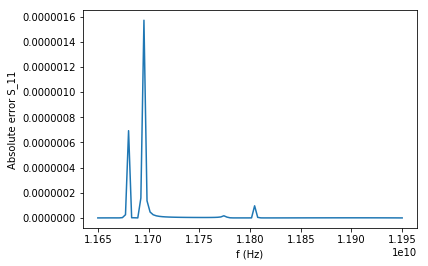

In [48]:
plt.plot(freq[::2]/ (2*np.pi), np.abs(S11_FEM - S11_MRI))
plt.ylabel('Absolute error S_11')
plt.xlabel('f (Hz)')